# Замощение доминошками
Есть старая известная задача: можно ли разрезать шахматную доску без двух противоположных по диагонали углов на "доминошки" -- фигурки, состоящие из двух клеток с общей стороной?

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
names = [name for hsv, name in by_hsv if name not in {'black', 'k', 'w', 'white', 'red'}]
import random
random.shuffle(names)
names.append('red')
names.append('white')
names.append('black')

In [2]:
def fill_cell(i, j, color, ax):
    ax.fill([i, i, i + 1, i + 1, i], [j, j + 1, j + 1, j, j], color=color)

def draw_filling(filling):
    if filling is not None:
        n = len(filling)
        m = len(filling[0])
        fig = plt.figure(figsize=(m * 0.75, n * 0.75))
        
        ax = fig.add_axes([0, 0, 1, 1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)      
        
        for name, spine in ax.spines.items():
            spine.set_visible(False)
            spine.set_visible(False)
        
        for i, row in enumerate(filling):
            i = n - i - 1
            for j, cell in enumerate(row):
                fill_cell(j, i, names[cell], ax)

        for i in range(n + 1):
            ax.plot([0, m], [i, i], color='black')
        for i in range(m + 1):
            ax.plot([i, i], [0, n], color='black')
        plt.close(fig)
        return fig
    else:
        return None

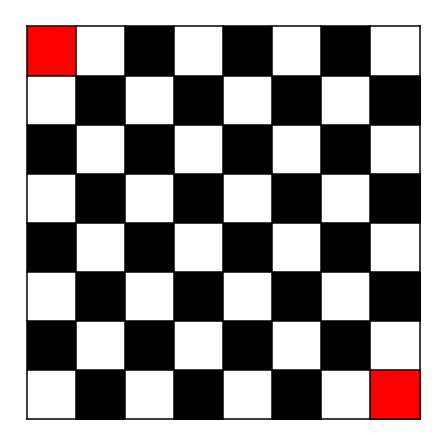

In [3]:
filling = [[-1 if (i + j) % 2 == 0 else -2 for j in range(8)] for i in range(8)]
filling[0][0] = -3
filling[7][7] = -3
draw_filling(filling)

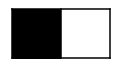

In [4]:
domino = [[-1, -2]]
draw_filling(domino)
# а вот и сама доминошка

Сделать это невозможно, и этому есть красивое и простое объяснение:
* На оставшейся части доски 30 черных и 32 белых клетки
* Каждая доминошка состоит из одной черной и одной белой клетки
* Как бы мы не разрезали фигуру на доминошки, в итоге на доминошках будет равное число белых и черных клеток

Давайте теперь разберем несколько методов, как можно:
* Понять, можно ли разрезать произвольную фигуру, составленную из клеток на плоскости, и если можно, то как
* Посчитать количество возможных вариантов разрезать, фигуру если существует хотя бы одно

## Динамическое программирование по профилю

Более подробно про этот подход написано [здесь](https://neerc.ifmo.ru/wiki/index.php?title=Динамическое_программирование_по_профилю), лично мне больше по душе <b>изломанный профиль</b>, про него и расскажу. Основной идеей динамического программирования является использование рекуррентных зависимостей функций, например одно из самых простых применений динамического программирования -- это подсчет чисел Фибоначчи, для которых справедливо соотношение
\begin{align*}
F_0&=F_1=1\\
F_{n+1}&=F_n+F_{n-1}
\end{align*}
Для подсчета $F_{100}$ мы можем последовательно вычислить все $F_i$ вплоть до $F_{100}$, просто последовательно применяя это рекуррентное соотношение. Чуть более сложный пример -- вычисление числа сочетаний, для которых справедливо
\begin{align*}
C_n^0&=1\\
C_n^k&=\frac{n}{k}C_{n-1}^{k-1} \\
C_n^k&=C_{n-1}^k+C_{n-1}^{k-1}
\end{align*}
В зависимости от задачи мы можем использовать одно из двух рекуррентных соотношений, в первом мы точно также как и с числами Фибоначчи последовательно вычисляем сочетания. Во втором же случае у нас появляется зависимость с двумя параметрами, но ситуация принципиально не изменяется: мы просто вычисляем в порядке увеличения $n$:

In [5]:
C = [[1]]
for n in range(1, 10):
    C.append([1]) # C[n][0] == 1
    for k in range(1, n):
        C[n].append(C[n - 1][k - 1] + C[n - 1][k])
    C[n].append(1)
        
# Дальнейший код просто чтобы вывести в виде треугольника Паскаля
def total_len(ints):
    return len(ints) + sum(map(len, map(str, ints))) - 1

def print_padded(ints, width):
    pad_len = width - total_len(ints)
    print(''.join([' ' for i in range(pad_len // 2)]), ' '.join(map(str, ints)), ''.join([' ' for i in range((pad_len + 1) // 2)]))

width = total_len(C[-1])
for row in C:
    print_padded(row, width)

              1              
             1 1             
            1 2 1            
           1 3 3 1           
          1 4 6 4 1          
        1 5 10 10 5 1        
      1 6 15 20 15 6 1       
     1 7 21 35 35 21 7 1     
   1 8 28 56 70 56 28 8 1    
 1 9 36 84 126 126 84 36 9 1 


Для замощения доминошками ситуация к сожалению гораздо сложние, как ни крути, но простого рекуррентного соотношения для функции "Каким числом способов можно замостить доминошками доску размера $n\times m$" не существует, тут надо что-нибудь придумывать. Здесь общая идея заключается примерно в следующем: давайте рассматрим следующую фигуру, состоящую из первых $k-1$ строк длины $m$ и каких-то клеточек на строке $k$

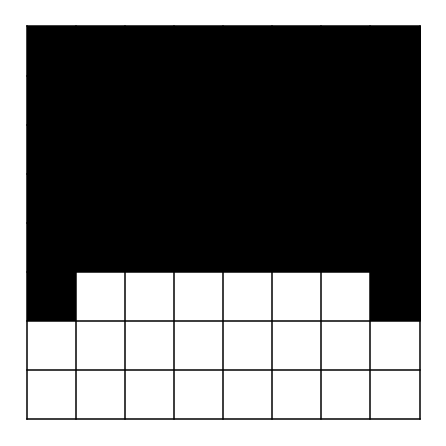

In [6]:
fig = [[-1 if i < 5 else (-1 if i == 5 and (random.randint(1, 10) <= 4) else -2) for j in range(8)] for i in range(8)]
draw_filling(fig)

Такая фигура однозначно задается тройкой $(k, m, p)$, где $0\leq p< 2^m$ -- число, двоичное представление которого указывает, какие клетки в последнем ряду используются, а какие нет (это число как раз принято называть <b>профилем</b>). Если обозначить за $f_m(k, p)$ количество способов замостить фигуру с такими параметрами, то оказывается, что 
$$
f_m(k+1, p)=\sum_{u\in U(p)}f_m(k, u),
$$
где $U(p)$ -- это множество профилей, из которых путем замощения остатка строки $k$ можно получить $p$ на следующей строке. Собственно такое представление возможно ровно из-за того, что одна доминошка затрагивает не больше двух строк. С алгоритмической точки зрения $U$ составляется перебором, в любом случае этот вариант профиля мне не очень нравится, о нем можно почитать в первоисточнике. Давайте теперь рассмотрим другой класс фигурок: как и прежде, у нас есть прямоугольник $(k-1)\times m$, на строке $k$ присутствуют первые $j$ клеток, остальные задаются профилем, на строке $k+1$ первые $j$ клеток задаются профилем, остальные не участвуют

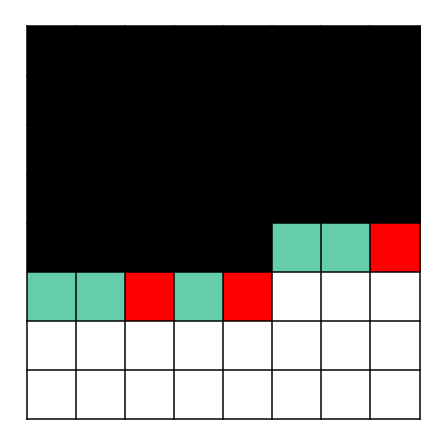

In [7]:
n = 8
m = 8
k = 4
j = 4
fig = [[-1 if i < k else -2 for j in range(8)] for i in range(8)]
profile = [0, 0, 1, 0, 1, 0, 0, 1]
for l in range(m):
    if l <= j:
        fig[k][l] = -1
        fig[k + 1][l] = -3 if profile[l] == 1 else -4
    else:
        fig[k][l] = -3 if profile[l] == 1 else -4
    
draw_filling(fig)

Фигура соответствует черным и красным клеткам, красные выделены для наглядности, за них отвечает профиль. По сравнению с предыдущими фигурками у нас добавилась одна степени свободы. Давайте побозначим за $g(k, j, m, p)$ количество способо замостить такую фигурку, тогда $g(k, m, m, p)=g(k+1, 0, m, p)$ и при этом $g(k, j, m, p)$ выражется через сумму нескольких $g(k, j - 1, m, \cdot)$. По большому счету переход от $j$ к $j+1$ -- это три варианта, первый -- поставить вертикальную доминошку, если это возможно

In [8]:
from animation_utils.animation import animate_list
fig_vertical_domino = [[-1 if i < k else -2 for j in range(8)] for i in range(8)]
profile = [0, 0, 1, 0, 1, 0, 0, 1]
for l in range(m):
    if l <= j:
        fig_vertical_domino[k][l] = -1
        fig_vertical_domino[k + 1][l] = -3 if profile[l] == 1 else -4
    else:
        fig_vertical_domino[k][l] = -3 if profile[l] == 1 else -4
fig_vertical_domino[k][j + 1] = -1
fig_vertical_domino[k + 1][j + 1] = -3
animate_list([draw_filling(fig), draw_filling(fig_vertical_domino)]);

interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…

второй -- поставить горизонтальную доминошку, если это возможно

In [9]:
fig_horizontal_domino = [[-1 if i < k else -2 for j in range(8)] for i in range(8)]
profile = [0, 0, 1, 0, 1, 0, 0, 1]
for l in range(m):
    if l <= j:
        fig_horizontal_domino[k][l] = -1
        fig_horizontal_domino[k + 1][l] = -3 if profile[l] == 1 else -4
    else:
        fig_horizontal_domino[k][l] = -3 if profile[l] == 1 else -4
fig_horizontal_domino[k][j + 1] = -1
fig_horizontal_domino[k + 1][j + 1] = -4
fig_horizontal_domino[k][j + 2] = -3
fig_horizontal_domino[k][j + 1] = -1

animate_list([draw_filling(fig), draw_filling(fig_horizontal_domino)]);

interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…

Или ничего не ставить, если клетка уже заполнена в профиле

In [10]:
fig_skip = [[-1 if i < k else -2 for j in range(8)] for i in range(8)]
profile = [0, 0, 1, 0, 1, 1, 0, 1]
for l in range(m):
    if l <= j:
        fig_skip[k][l] = -1
        fig_skip[k + 1][l] = -3 if profile[l] == 1 else -4
    else:
        fig_skip[k][l] = -3 if profile[l] == 1 else -4
fig[k][j + 1] = -3
fig_skip[k][j + 1] = -1
fig_skip[k + 1][j + 1] = -4


animate_list([draw_filling(fig), draw_filling(fig_skip)]);

interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…

Очень важным является то, что несложно в эту логику добавить заранее покрытые клетки. Таким образом мы сможем посчитать число способов замощения для произвольной фигуры на плоскости. Давайте собственно попробуем это реализовать. Начнем с шахматной доски

In [11]:
tiling = [
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
]

In [12]:
def count_tilings(tiling):
    n = len(tiling)
    m = len(tiling[0])
    if ((n + 1) * m * 2 ** m) <= 10000000:
        dp = [[[(0 if k != 0 or j != 0 or mask != 0 else 1) for mask in range(2 ** m)] for j in range(m)] for k in range(n + 1)]
    for k in range(n):
        for j in range(m):
            for mask in range(2 ** m):
                # Вертикальная доминошка
                if k < n - 1 and tiling[k][j] == '.' and tiling[k + 1][j] == '.' and (mask &  (1 << j)) == 0:
                    dp[k + ((j + 1) // m)][(j + 1) % m][mask + (1 << j)] += dp[k][j][mask]
                # Горизонтальная доминошка
                if j < m - 1 and tiling[k][j] == '.' and tiling[k][j + 1] == '.' and (mask & (3 << j)) == 0:
                    dp[k + ((j + 1) // m)][(j + 1) % m][mask + (2 << j)] += dp[k][j][mask]
                # Клетка занята
                if ((1 << j) &  mask) != 0 or tiling[k][j] != '.':
                    dp[k + ((j + 1) // m)][(j + 1) % m][(mask | (1 << j)) - (1 << j)] += dp[k][j][mask]
    return dp

In [13]:
dp = count_tilings(tiling)
print(dp[8][0][0])

12988816


Отлично, получили как раз то, что нужно, можно свериться с [соответствующей последовательностью](https://oeis.org/A004003). Заодно можно свериться с числами Фибоначчи (количество способов замостить доминошками полоску $2\times n$ -- это $n-1$-ое число Фибоначчи)

In [14]:
tiling_fib = [
    '..',
    '..',
    '..',
    '..',
    '..',
    '..',
    '..',
    '..'
]
dp = count_tilings(tiling_fib)
for i in range(8):
    print(dp[i][0][0], end=' ')

1 1 2 3 5 8 13 21 

Ну и давайте проверим для доски с вырезанными клетками

In [15]:
tiling_no_corners_opposite = [
    '.......#',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '#.......',
]
dp = count_tilings(tiling_no_corners_opposite)
print(dp[8][0][0])

0


Давайте попробуем сделать какое-нибудь замощение, если это возможно. Для это обычно в динамическом программировании используется стандартный способ: пройтись в обратном порядке по тем состояниям, которые привели хотя бы к одному способу замощения.

In [16]:
def cover_if_possible(tiling, dp=None):
    if dp is None:
        dp = count_tilings(tiling)
    n = len(dp) - 1
    m = len(dp[0])
    if dp[n][0][0] == 0:
        return None
    
    result = [[-1 if tiling[i][j] == '#' else 0 for j in range(m)] for i in range(n)]
    num = 0
    
    k = n
    j = 0
    mask = 0
    
    while k > 0 or j > 0:
        #print(k, j, mask)
        prev_j = j - 1
        prev_k = k
        if prev_j == -1:
            prev_j += m
            prev_k -= 1
        
        # Начинаем перебирать варианты, каким образом мы могли попасть в i, j, mask
        # Этот вариант очень не оптимален, но занимает меньше кода и все равно быстрее 
        # самого подсчета динамики
        for prev_mask in range(2 ** m):
            if prev_k < n - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k + 1][prev_j] == '.' and \
                (prev_mask & (1 << prev_j)) == 0 and (prev_mask + (1 << prev_j)) == mask and dp[prev_k][prev_j][prev_mask] != 0:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k + 1][prev_j] = num
                #print(f'Vertical at ({prev_k}, {prev_j}) ({prev_k + 1}, {prev_j})')
                num += 1
                break
            elif prev_j < m - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k][prev_j + 1] == '.' and (prev_mask & (3 << prev_j)) == 0 and \
                prev_mask + (2 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] != 0:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k][prev_j + 1] = num
                #print(f'Horisontal at ({prev_k}, {prev_j}) ({prev_k}, {prev_j + 1})')
                num += 1
                break
            elif (((1 << prev_j) & prev_mask) != 0 or tiling[prev_k][prev_j] != '.') and \
                (prev_mask | (1 << prev_j)) - (1 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] != 0:
                mask = prev_mask
                break
        
        j = prev_j
        k = prev_k
    
    return result

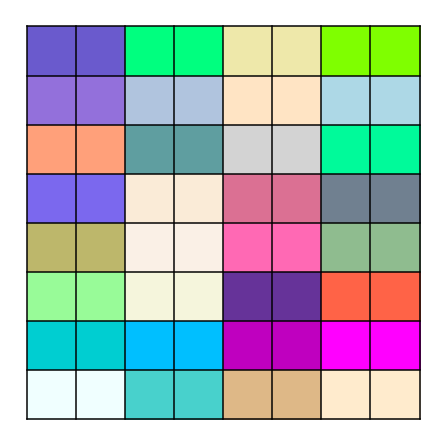

In [17]:
filling = cover_if_possible(tiling)
draw_filling(filling)

Здесь ничего интересного, давайте вырежем несколько клеток

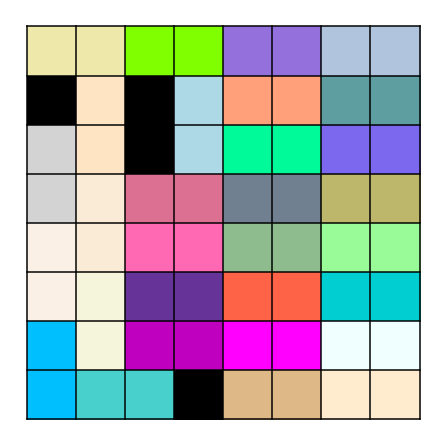

In [18]:
tiling_random = [
    '........',
    '#.#.....',
    '..#.....',
    '........',
    '........',
    '........',
    '........',
    '...#....'
]
filling_random = cover_if_possible(tiling_random)
draw_filling(filling_random)

Ладно, с количеством вроде бы разобрались. А что если мы просто хотим понять, получится ли замостить или нет? Можно использовать тот же самый способ для подсчета максимального числа клеток, которое можно замостить. Для этого нужно добавить переход "пропустить клетку" и заменить сумму на минимум в рекуррентном соотношении. В целом получается как-то так

In [19]:
def maxmimum_cover(tiling):
    n = len(tiling)
    m = len(tiling[0])
    if ((n + 1) * m * 2 ** m) <= 10000000:
        dp = [[[(n * m if k != 0 or j != 0 or mask != 0 else 0) for mask in range(2 ** m)] for j in range(m)] for k in range(n + 1)]
    for k in range(n):
        for j in range(m):
            for mask in range(2 ** m):
                next_k, next_j = k + ((j + 1) // m), (j + 1) % m
                # Вертикальная доминошка
                if k < n - 1 and tiling[k][j] == '.' and tiling[k + 1][j] == '.' and (mask &  (1 << j)) == 0:
                    dp[next_k][next_j][mask + (1 << j)] = min(dp[next_k][next_j][mask + (1 << j)], dp[k][j][mask])
                # Горизонтальная доминошка
                if j < m - 1 and tiling[k][j] == '.' and tiling[k][j + 1] == '.' and (mask & (3 << j)) == 0:
                    dp[next_k][next_j][mask + (2 << j)] = min(dp[next_k][next_j][mask + (2 << j)], dp[k][j][mask])
                # Клетка занята
                if ((1 << j) &  mask) != 0 or tiling[k][j] != '.':
                    dp[next_k][next_j][(mask | (1 << j)) - (1 << j)] = \
                        min(dp[next_k][next_j][(mask | (1 << j)) - (1 << j)], dp[k][j][mask])
                # Клетка не занята, рассмотриваем случай её пропуска
                else:
                    dp[next_k][next_j][(mask | (1 << j)) - (1 << j)] = \
                        min(dp[next_k][next_j][(mask | (1 << j)) - (1 << j)], dp[k][j][mask] + 1)
    return dp

def cover_maximum_possible(tiling, dp=None):
    if dp is None:
        dp = maxmimum_cover(tiling)
    n = len(dp) - 1
    m = len(dp[0])

    result = [[-1 if tiling[i][j] == '#' else -2 for j in range(m)] for i in range(n)]
    num = 0
    
    k = n
    j = 0
    mask = 0
    
    while k > 0 or j > 0:
        #print(k, j, mask)
        prev_j = j - 1
        prev_k = k
        if prev_j == -1:
            prev_j += m
            prev_k -= 1
        
        # Начинаем перебирать варианты, каким образом мы могли попасть в i, j, mask
        # Этот вариант очень не оптимален, но занимает меньше кода и все равно быстрее 
        # самого подсчета динамики
        for prev_mask in range(2 ** m):
            # Раньше мы здесь проверяли, что количество вариантов в этой ветке не 0, сейчас нужно
            # проверить, что эта ветка ведет к максимальному покрытию
            if prev_k < n - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k + 1][prev_j] == '.' and \
                    (prev_mask & (1 << prev_j)) == 0 and (prev_mask + (1 << prev_j)) == mask and \
                    dp[prev_k][prev_j][prev_mask] == dp[k][j][mask]:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k + 1][prev_j] = num
                num += 1
                break
            elif prev_j < m - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k][prev_j + 1] == '.' and (prev_mask & (3 << prev_j)) == 0 and \
                    prev_mask + (2 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] == dp[k][j][mask]:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k][prev_j + 1] = num
                num += 1
                break
            elif (((1 << prev_j) & prev_mask) != 0 or tiling[prev_k][prev_j] != '.') and \
                    (prev_mask | (1 << prev_j)) - (1 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] == dp[k][j][mask]:
                mask = prev_mask
                break
            elif ((1 << prev_j) & prev_mask) == 0 and tiling[prev_k][prev_j] == '.' and \
                    (prev_mask | (1 << prev_j)) - (1 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] + 1 == dp[k][j][mask]:
                mask = prev_mask
                break
                
        
        j = prev_j
        k = prev_k
    
    return result

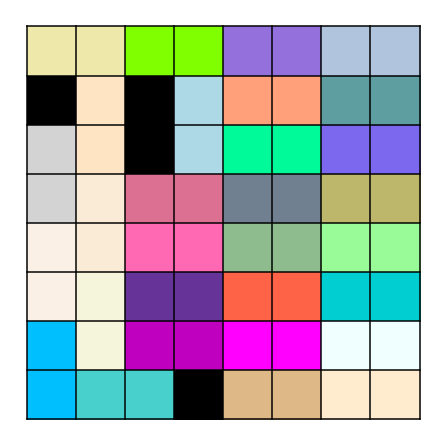

In [20]:
filling = cover_maximum_possible(tiling_random)
draw_filling(filling)

А вот нетривиальный пример, когда замостить не получается, но количество черных и белых клеток одинаково

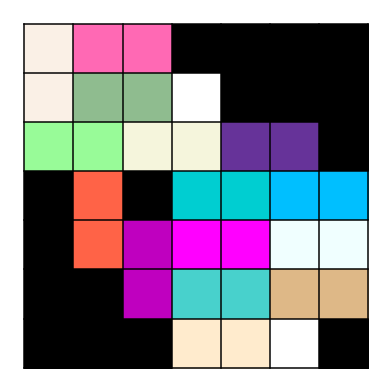

In [21]:
tiling_custom=[
    '...####',
    '....###',
    '......#',
    '#.#....',
    '#......',
    '##.....',
    '###...#',
]
filling = cover_maximum_possible(tiling_custom)
draw_filling(filling)

## Замощение с помощью решения задачи о максимальном паросочетнии
Возвращаясь к черно-белой раскраске как на шахматной доске, можно заметить интересную интерпретацию задачи замощения доминошками. Давайте посмотрим на граф, в котором клетки фигуры -- это вершины, ребрами соеденины клетки, имющие общую сторону. Так вот, доминошка в этом графе -- это как раз ребро. Если раскрасить граф в шахматном порядке, то внезапмно можно обнаружить, что этот граф -- двудольный, черные -- одна доля, белые -- другая. Если переформулировать задачу замощения наибольшего числа клеток в терминах этого графа, то получается, что нужно найти максимальное по размеру множество ребер такое, чтобы вершины являлись концом не более одного ребра. В общем то, это довольно известная [задача о максимальном паросочетании](https://ru.wikipedia.org/wiki/Паросочетание). Давайте попробуем её применить для решения этой задачи, тут получится даже с анимацией, приведу базовый алгоритм Куна для нахождения максимального паросочетания

In [22]:
def check_valid(i, j, n, m, tiling):
    return 0 <= i and i < n and 0 <= j and j < m and tiling[i][j] != '#'

def find_augmenting_path(x, y, n, m, visited, matched, tiling):
    if not check_valid(x, y, n, m, tiling):
        return False
    if (x, y) in visited:
        return False
    visited.add((x, y))
    
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        if not check_valid(x + dx, y + dy, n, m, tiling):
            continue
        if (x + dx, y + dy) not in matched or find_augmenting_path(*matched[(x + dx , y + dy)], n, m, visited, matched, tiling):
            matched[(x + dx, y + dy)] = (x, y)
            return True
    return False

def convert_match(matched, tiling, n, m):
    result = [[-1 if tiling[i][j] == '#' else -2 for j in range(m)] for i in range(n)]
    num = 0
    for x, y in matched:
        _x, _y = matched[(x, y)]
        result[x][y] = num
        result[_x][_y] = num
        num += 1
    return result

def match_with_flow(tiling):
    result_slices = []
    n = len(tiling)
    m = len(tiling[0])
    
    matched = dict()
    # Для наглядности визуализации
    rows = list(range(n))
    columns = list(range(m))
    random.shuffle(rows)
    random.shuffle(columns)
    result_slices.append(convert_match(matched, tiling, n, m))
            
    for i in rows:
        for j in columns:
            if (i + j) % 2 == 1:
                continue
            visited = set()
            if find_augmenting_path(i, j, n, m, visited, matched, tiling):
                result_slices.append(convert_match(matched, tiling, n, m))
            
    return result_slices

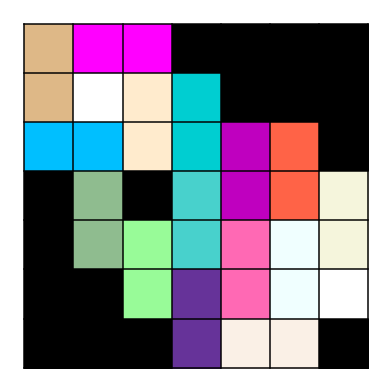

In [23]:
sequencial_match = match_with_flow(tiling_custom)
filling = sequencial_match[-1]
draw_filling(filling)

In [24]:
animate_list(list(map(draw_filling, sequencial_match)), play=True);

Play(value=0)

interactive(children=(IntSlider(value=0, description='idx', max=15), Output()), _dom_classes=('widget-interact…

Суть алгоритма Куна (да и любого другого алгоритм для нахождения максимального паросочетания) заключается в нахождении "аугментирующих путей". В терминах доминошек это цепочки из доминошек, у которых на обоих концах рядом есть по свободной клетке, такие цепочки можно заменить на цепочки большей длины, охватывающие эти клетки. Более того, основное утверждение, на котором работают все алгоритмы нахождения максимального паросочетания, заключается в том, что если такой цепочки не удается найти, то значит большего замощения нам не получить